# Basic classification: Classify images of clothing with RedisAI

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.


[RedisAI](https://oss.redislabs.com/redisai/) is a popular model server for running ML models. RedisAI both maximizes computation throughput and reduces latency by adhering to the principle of data locality , as well as simplifies the deployment and serving of graphs by leveraging on Redis' production-proven infrastructure.

In this handbook, I will deploy a tensorflow models to RedisAI with BentoML


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install bentoml tensorflow matplotlib numpy pillow

In [3]:
# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

## Build the image preprocessing

Ankle boot


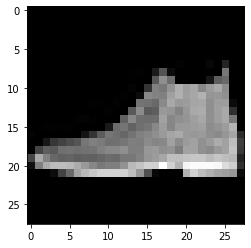

In [5]:
# import cv2
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

# cv2.imwrite("test.png", d_test_img)
plt.imshow(d_test_img, cmap='gray')

## Train the model


In [ ]:
model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28), name="input"),
            tf.keras.layers.Dense(128, activation='relu', name="dense"),
            tf.keras.layers.Dense(10, activation='softmax',name="output" )
        ])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)

2021-09-28 09:51:36.650415: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-28 09:51:36.650458: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-28 09:51:36.650485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vts-datnt114): /proc/driver/nvidia/version does not exist
2021-09-28 09:51:36.650756: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-28 09:51:36.674715: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2799925000 Hz
2021-09-28 09:51:36.675439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f566c000b20 initialized for platform Host (this does not guarantee th

Epoch 1/10
1875/1875 [==============================] - 2s 856us/step - loss: 0.4945 - accuracy: 0.8271
Epoch 2/10
1875/1875 [==============================] - 2s 800us/step - loss: 0.3729 - accuracy: 0.8657
Epoch 3/10
1875/1875 [==============================] - 1s 764us/step - loss: 0.3352 - accuracy: 0.8772
Epoch 4/10
1875/1875 [==============================] - 1s 738us/step - loss: 0.3105 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 1s 741us/step - loss: 0.2950 - accuracy: 0.8911
Epoch 6/10
1875/1875 [==============================] - 1s 759us/step - loss: 0.2822 - accuracy: 0.8949
Epoch 7/10
1875/1875 [==============================] - 1s 749us/step - loss: 0.2656 - accuracy: 0.9019
Epoch 8/10
1875/1875 [==============================] - 1s 746us/step - loss: 0.2562 - accuracy: 0.9041
Epoch 9/10
 407/1875 [=====>........................] - ETA: 1s - loss: 0.2375 - accuracy: 0.9093

## Model inference test run

In [ ]:
from PIL import Image
img = Image.open('test.png')
print(np.array(img).shape)

In [ ]:
img = np.array(img)
img = np.expand_dims(img, axis=0)

predict = model.predict(img)
klass = tf.argmax(predict, axis=1)
[class_names[c] for c in klass]

And the model predicts a label as expected.

Because RedisAI currently supports PyTorch (libtorch), Tensorflow (libtensorflow) (max version is 1.15.0), TensorFlow Lite, and ONNXRuntime as backends; Keras and TensorFlow 2.x are supported through graph freezing.  Note that a frozen graph will be executed using the TensorFlow 1.15 backend.

We export a frozen graph from Keras and TensorFlow 2.xs as follows:

In [ ]:
# Reference: https://github.com/leimao/Frozen-Graph-TensorFlow/blob/master/TensorFlow_v2/example_2.py

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2


full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

#  Model Serving with BentoML

## Custom Artifact with Redisai

If you are new to RedisAI and trying it out for the first time, you might not know the setup already (although it's quite easy to setup a local RedisAI instance). In that's the case, you need pull the latest docker image of RedisAI (yes, you need docker installed in your machine for this to work), run it on the default port, deploy the model you specified.

Run docker redisai if cpu:
```
docker run -dp 6379:6379 -it --rm  redislabs/redisai:edge-cpu-bionic
```
and if gpu:
```
docker run -p 6379:6379 --gpus all -it --rm redislabs/redisai:edge-gpu-bionic
```

See all tag image rediasai [here](https://hub.docker.com/r/redislabs/redisai/tags?page=1&ordering=last_updated). 

PS: It's IMPORTANT to note that this API leaves the docker container running. You would need to manually stop the container once you are done with experimentation. Also, remember that if you trying to run this API twice without killing the first container, it throws an error saying the port is already in use.

Here we will use redisai cpu.


In [ ]:
!docker run -dp 6379:6379 -it --rm  redislabs/redisai:edge-cpu-bionic

The following code creates a subclass from the BentoServiceArtifact. It implements how to save and load the model.

In the initialization of the artifact, we have the following parameters:

- backend : the backend used by the model as a String
- device : the device used to execute the model as a String
- inputs : array reply with one or more names of the model's input nodes (applicable only for TensorFlow models). 
- outputs : array reply with one or more names of the model's output nodes (applicable only for TensorFlow models)

**Here, names of the model's input nodes is 'x' and outputs note is 'Identity' (see Frozen model layers above)**

This code was built based on A plugin that integrates RedisAI with MLflow pipeline https://github.com/RedisAI/mlflow-redisai.


In [ ]:
%%writefile redisai_artifact.py
import os
from bentoml.exceptions import (
    BentoMLException,
    InvalidArgument,
    MissingDependencyException,
)

from bentoml.service.artifacts import BentoServiceArtifact
import redisai as rai
import logging

logger = logging.getLogger(__name__)


# Connection parameters
class Config(dict):
    def __init__(self):
        super().__init__()
        self['host'] = 'localhost'
        self['port'] = 6379
        self['username'] = None
        self['password'] = None
        self['db'] = 0


SUPPORTED_BACKEND = ["torch", "tf", "onnx"]
file_extension = {
    'torch': '.pt',
    'tf'   : '.pb',
    'onnx' : '.onnx'}


class RedisaiArtifact(BentoServiceArtifact):
    def __init__(self, name, backend='torch', input=None, output=None, device='cpu'):
        super(RedisaiArtifact, self).__init__(name)
        if backend not in SUPPORTED_BACKEND:
            raise BentoMLException(
                f'"{backend}" runtime is currently not supported for RedisaiArtifact'
            )
        server_config = Config()
        # Connecting to a RedisAI 
        self.con = rai.Client(**server_config)
        self._input = input
        self._output = output
        self._backend = backend
        self._device = device
        self._model = None

    def pack(self, model):
        if self._backend == 'torch':
            try:
                import torch
            except ImportError:
                raise MissingDependencyException(
                    "torch package is required to use RedisaiArtifact"
                )

            if not isinstance(model, torch.nn.Module):
                raise InvalidArgument(
                    "RedisaiArtifact can only pack type 'torch.jit.ScriptModule'"
                )

        elif self._backend == 'tf':
            try:
                import tensorflow as tf

            except ImportError:
                raise MissingDependencyException(
                    "Tensorflow package is required to use RedisaiArtifact."
                )

        elif self._backend == 'onnx':
            try:
                import onnx

                if not isinstance(model, onnx.ModelProto):
                    raise InvalidArgument(
                        "onnx.ModelProto model file path is required to "
                        "pack an RedisaiArtifact"
                    )

            except ImportError:
                raise InvalidArgument(
                    "ONNX package is required to use RedisaiArtifact."
                )

        self._model = model

        return self

    def get(self):
        return self.con

    def save(self, dst):

        if self._backend == 'torch':
            import torch

            if self._model.training is True:
                logger.warn('Graph is in training mode. Converting to evaluation mode')

                self._model.eval()

            torch.jit.save(self._model, self._file_path(dst))

        elif self._backend == 'tf':
            import tensorflow as tf

            TF2 = tf.__version__.startswith('2')
            if TF2:
                tf.io.write_graph(graph_or_graph_def=self._model.graph,
                                  logdir=dst,
                                  name=self.name + file_extension[self._backend],
                                  as_text=False)
            else:
                tf.compat.v1.disable_eager_execution()
                tf.train.write_graph(self._model, dst, self.name + file_extension[self._backend], as_text=False)

        elif self._backend == 'onnx':
            import onnx
            onnx.save_model(self._model, self._file_path(dst))

        return self

    def load(self, path):
        with open(self._file_path(path), 'rb') as f:
            model_redisai = f.read()

        self.con.modelstore(self.name, self._backend, self._device, model_redisai, inputs=self._input,
                            outputs=self._output)


    def _file_path(self, base_path):
        return os.path.join(base_path, self.name + file_extension[self._backend])


## Define and save BentoService with the custom Artifact

In [ ]:
%%writefile tensorflow_fashion_mnist.py
from typing import List, BinaryIO
import bentoml
import tensorflow as tf
from PIL import Image
import numpy as np

# from bentoml.frameworks.tensorflow import TensorflowSavedModelArtifact
from redisai_artifact import RedisaiArtifact
from bentoml.adapters import FileInput
from bentoml import BentoService, env, api, artifacts

FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@env(pip_packages=['tensorflow', 'numpy', 'pillow'])
# @artifacts([TensorflowSavedModelArtifact('model')])
@artifacts([RedisaiArtifact('model', 'tf', 'x', 'Identity')])
class FashionMnistTensorflow(BentoService):

    @api(input=FileInput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        inputs = []
        
        for fs in file_streams:
            print(fs)
            img = Image.open(fs)
            img = np.array(img)/225
            img = np.expand_dims(img, axis=0)
            inputs.append(img)
        imgs = np.vstack(inputs).astype(dtype=np.float32)    
        
        con = self.artifacts.model
        con.tensorset('x', imgs, dtype='float')
 
        con.modelrun('model', 'x', 'Identity')
        outputs = con.tensorget('Identity')
        output_classes = outputs.argmax(axis=1)

        return [FASHION_MNIST_CLASSES[c] for c in output_classes]

Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [ ]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", frozen_func)
saved_path = bento_svc.save()

## Use BentoService with BentoML CLI

**`bentoml get <BentoService Name>` list all of BentoService's versions**

In [ ]:
!bentoml get FashionMnistTensorflow

**`bentoml get <BentoService name>:<bentoService version>` display detailed information of the specific BentoService version**

In [ ]:
!bentoml get FashionMnistTensorflow:latest 

**Serve bentoml REST server locally**

In [ ]:
!bentoml serve FashionMnistTensorflow:latest

Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@test.png"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@test.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [ ]:
!bentoml run FashionMnistTensorflow:latest predict  --input-file test.png

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)